In [1]:
import serial
import time
import numpy as np
import wfdb
from datetime import datetime
from scipy.signal import butter, find_peaks, sosfiltfilt, iirnotch, filtfilt, find_peaks
import matplotlib.pyplot as plt

In [3]:
arquivo_txt = r'C:\Users\Stella\Desktop\TCC\ecg_bruto.txt'

valores = []

with open(arquivo_txt, 'r') as f:
    for linha in f:
        valor = int(linha.strip())
        valores.append(valor)

print(f"📂 {len(valores)} amostras carregadas do arquivo {arquivo_txt}")
print(f"🔎 Primeiras 10 amostras: {valores[:10]}")


📂 14655 amostras carregadas do arquivo C:\Users\Stella\Desktop\TCC\ecg_bruto.txt
🔎 Primeiras 10 amostras: [9, 1651, 1812, 1821, 1835, 1824, 1830, 1835, 1837, 1821]


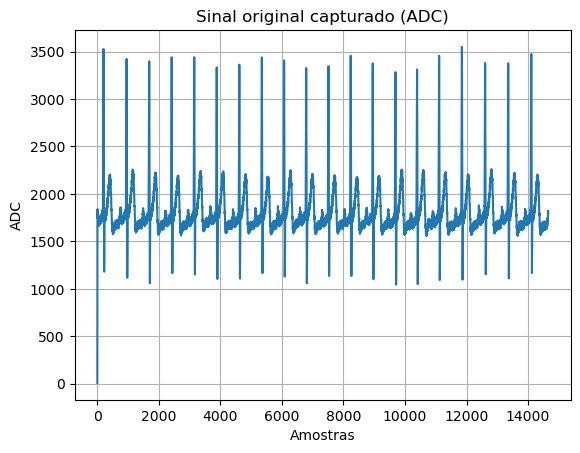

In [5]:
valores_adc = np.array(valores)
plt.plot(valores_adc)
plt.title("Sinal original capturado (ADC)")
plt.xlabel("Amostras")
plt.ylabel("ADC")
plt.grid()
plt.show()

In [7]:
# === CONFIGURAÇÕES DO ADC E SINAL ===
adc_bits = 12
adc_max = 2**adc_bits - 1  # 4095
v_ref = 3.3  # volts
ganho_adc = 1  # 1 unidade = 5 µV → evita estouro com fmt='16'
taxa_amostragem = 977

# === CONVERSÃO E PRÉ-PROCESSAMENTO ===
sinal_adc = np.array(valores)
sinal_mv = (sinal_adc / adc_max) * v_ref * 1000  # converte para mV primeiro

# Remove média DC (valor médio)
sinal_mv = sinal_mv - np.mean(sinal_mv)  # remove DC offset (média do sinal)

# Normalização considerando ganho aproximado (AD8232):
ganho_sensor = 1100  # em mV (ajuste conforme necessário)
sinal_centralizado = sinal_mv / ganho_sensor

# === CONFIGURAÇÕES SERIAL E ARQUIVO ===
taxa_amostragem = 977
arquivo_wfdb = 'meu_ecg_filtrado'

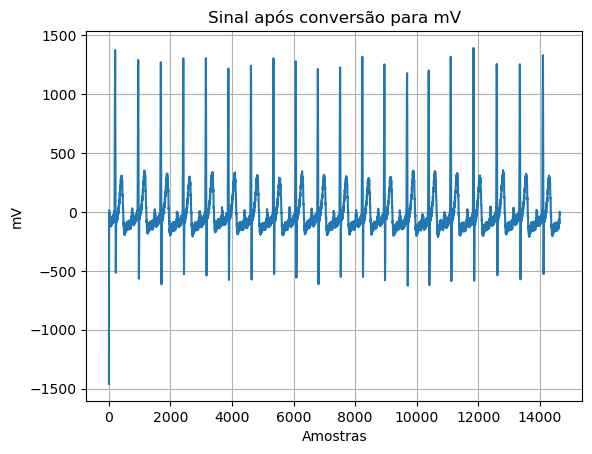

In [9]:
plt.plot(sinal_mv)
plt.title("Sinal após conversão para mV")
plt.xlabel("Amostras")
plt.ylabel("mV")
plt.grid()
plt.show()

In [11]:
if max(valores) >= adc_max:
    print("⚠️ Sinal saturado, reduzir ganho ou ajustar circuito.")

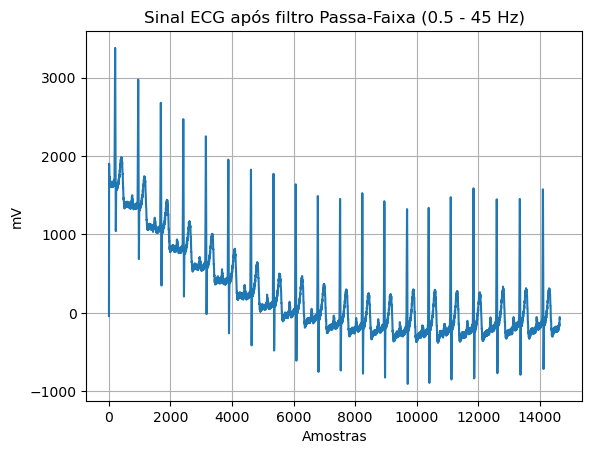

In [13]:
# === FILTRO PASSA-FAIXA ===
def filtro_passa_faixa(signal, fs, lowcut=0.5, highcut=45.0, ordem=2):
    nyq = 0.5 * fs
    sos = butter(ordem, [lowcut / nyq, highcut / nyq], btype='band', output='sos')
    return sosfiltfilt(sos, signal)
    
sinal_filtrado = filtro_passa_faixa(valores, taxa_amostragem, lowcut=0.05, highcut=100.0)

plt.plot(sinal_filtrado)
plt.title("Sinal ECG após filtro Passa-Faixa (0.5 - 45 Hz)")
plt.xlabel("Amostras")
plt.ylabel("mV")
plt.grid()
plt.show()

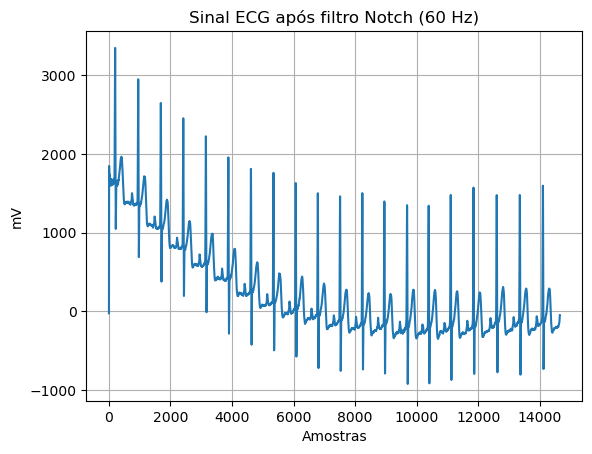

In [15]:

# === FILTRO NOTCH 60 Hz ===
def filtro_notch(signal, fs, f_notch=60.0, Q=30):
    b, a = iirnotch(f_notch, Q, fs)
    return filtfilt(b, a, signal)

sinal_filtrado = filtro_notch(sinal_filtrado, taxa_amostragem)

plt.plot(sinal_filtrado)
plt.title("Sinal ECG após filtro Notch (60 Hz)")
plt.xlabel("Amostras")
plt.ylabel("mV")
plt.grid()
plt.show()


In [17]:
# === PROTEÇÃO PARA FORMATO fmt='16' DO WFDB ===
adc_gain = 1000  # 1000 μV por unidade
sinal_limpo = sinal_filtrado / np.max(np.abs(sinal_filtrado)) * 2.0  # amplitude máx de ±2 mV
sinal_final = sinal_limpo.reshape(-1, 1)  # formato (n, 1)

# === SALVANDO COMO WFDB (.dat + .hea) ===
wfdb.wrsamp(
    record_name=arquivo_wfdb,
    fs=taxa_amostragem,
    sig_name=['ECG'],
    units=['mV'],
    p_signal=sinal_final,
    fmt=['16'],
    adc_gain=[adc_gain],
    baseline=[0],
    comments=[f"Capturado, filtrado e ajustado em {datetime.now()}"]
)

In [19]:
# Reabre e ajusta os metadados (adcres)
record = wfdb.rdrecord(arquivo_wfdb)
record.adcres = [12]
record.wrheader()

print(f"✅ Arquivo WFDB salvo como: {arquivo_wfdb}.dat + {arquivo_wfdb}.hea")

# === DETECÇÃO DE BATIMENTOS E GERAÇÃO DO ATRIBUTO .atr ===
picos, _ = find_peaks(sinal_limpo, distance=taxa_amostragem * 0.3, height=0.1, prominence=0.05)

if len(picos) == 0:
    print("⚠️ Nenhum batimento detectado. .atr não será gerado.")
else:
    symbols = ['N'] * len(picos)
    wfdb.wrann(
        record_name=arquivo_wfdb,
        extension='atr',
        sample=picos,
        symbol=symbols,
        fs=taxa_amostragem
    )
    print(f"📝 Anotações (.atr) geradas com {len(picos)} batimentos (símbolo 'N')")

✅ Arquivo WFDB salvo como: meu_ecg_filtrado.dat + meu_ecg_filtrado.hea
📝 Anotações (.atr) geradas com 20 batimentos (símbolo 'N')
